In [1]:
REALTIME_ESTIMATOR = False
WEEK = 74

In [2]:
from google.cloud import bigquery
from google.cloud import bigquery_storage
import warnings
import requests
import time
from web3 import Web3
import pandas as pd
from urllib.request import urlopen
import json
import os

Consider installing rusty-rlp to improve pyrlp performance with a rust based backend


In [3]:
# constants
week_1_start_ts = 1590969600
week_end_timestamp = week_1_start_ts + WEEK * 7 * 24 * 60 * 60
week_start_timestamp = week_end_timestamp - 7 * 24 * 60 * 60
BAL_addresses = {
    1: '0xba100000625a3754423978a60c9317c58a424e3d',
    137: '0x9a71012b13ca4d3d0cdc72a177df3ef03b0e76a3',
    42161: '0x040d1edc9569d4bab2d15287dc5a4f10f56a56b8'
}
networks = {
    1: 'ethereum',
    137: 'polygon',
    42161: 'arbitrum'
}
CLAIM_PRECISION = 12 # leave out of results addresses that mined less than CLAIM_THRESHOLD
CLAIM_THRESHOLD = 10**(-CLAIM_PRECISION)
reports_dir = f'reports/{WEEK}'
if not os.path.exists(reports_dir):
    os.mkdir(reports_dir)
def get_export_filename(network, token):
    return f'{reports_dir}/__{network}_{token}.json'

In [4]:
if REALTIME_ESTIMATOR:
    warnings.warn('Running realtime estimator')
    
    from urllib.request import urlopen
    import json
    url = 'https://raw.githubusercontent.com/balancer-labs/bal-mining-scripts/master/reports/_current.json'
    jsonurl = urlopen(url)
    claims = json.loads(jsonurl.read())
    claimable_weeks = [20+int(w) for w in claims.keys()]
    most_recent_week = max(claimable_weeks)
    # delete the estimates for the most recent published week, since now there's an official value available on IPFS
    project_id = os.environ['GCP_PROJECT']
    sql = f'''
        DELETE FROM {project_id}.bal_mining_estimates.lp_estimates_multitoken
        WHERE week = {most_recent_week}
    '''
    client = bigquery.Client()
    query = client.query(sql)
    query.result()
    
    
    from datetime import datetime
    week_1_start = '01/06/2020 00:00:00 UTC'
    week_1_start = datetime.strptime(week_1_start, '%d/%m/%Y %H:%M:%S %Z')
    WEEK = int(1 + (datetime.utcnow() - week_1_start).days/7)  # this is what week we're actually in
    week_end_timestamp = week_1_start_ts + WEEK * 7 * 24 * 60 * 60
    week_start_timestamp = week_end_timestamp - 7 * 24 * 60 * 60
    week_end_timestamp = int(datetime.utcnow().timestamp())
    week_passed = (week_end_timestamp - week_start_timestamp)/(7*24*3600)

In [5]:
# get addresses that redirect
if REALTIME_ESTIMATOR:
    url = 'https://raw.githubusercontent.com/balancer-labs/bal-mining-scripts/master/config/redirect.json'
    jsonurl = urlopen(url)
    redirects = json.loads(jsonurl.read())
else:
    redirects = json.load(open('config/redirect.json'))

In [6]:
def get_bpt_supply_gbq(pools_addresses,
                   network):

    network_blocks_table = {
        1: 'bigquery-public-data.crypto_ethereum.blocks',
        137: 'public-data-finance.crypto_polygon.blocks',
        42161: 'nansen-datasets-prod.crypto_arbitrum.blocks'
    }

    bpt_balances_table = {
        1: 'blockchain-etl.ethereum_balancer.view_liquidity_mining_power',
        137: 'blockchain-etl.polygon_balancer.view_liquidity_mining_power',
        42161: 'blockchain-etl.arbitrum_balancer.view_V2_bpt_balances'
    }

    sql = '''
        DECLARE pool_addresses ARRAY<STRING>;
        SET pool_addresses = [
            '{0}'
        ];

        SELECT block_number, token_address, SUM(balance)/1e18 AS supply
        FROM `{1}`
        WHERE token_address IN UNNEST(pool_addresses)
        AND address <> '0x0000000000000000000000000000000000000000'
        AND balance > 0
        AND block_number = (
            SELECT MAX(number) FROM `{2}`
            WHERE timestamp <= TIMESTAMP_SECONDS({3}))
        GROUP BY block_number, token_address
    '''.format(
        '\',\''.join(pools_addresses),
        bpt_balances_table[network],
        network_blocks_table[network],
        week_end_timestamp
    )
#     print(sql)
    
    client = bigquery.Client()
    bqstorageclient = bigquery_storage.BigQueryReadClient()
    BPT_supply_df = (
        client.query(sql)
        .result()
        .to_dataframe(bqstorage_client=bqstorageclient)
    )
    return BPT_supply_df

In [7]:
def get_bpt_supply_subgraph(pools_addresses,
                            time_travel_block,
                            network):

    endpoint = {
        1: 'https://api.thegraph.com/subgraphs/name/balancer-labs/balancer-v2',
        137: 'https://api.thegraph.com/subgraphs/name/balancer-labs/balancer-polygon-v2',
        42161: 'https://api.thegraph.com/subgraphs/name/balancer-labs/balancer-arbitrum-v2'
    }

    query = '''
        {
          pools(
                block: {number: {}},
                where:{address_in:
              ["{}"]
            }
          ) {
            address
            totalShares
          }
        }
    '''.replace('{','{{').replace('}','}}').replace('{{}}','{}').format(
        time_travel_block,
        '","'.join(pools_addresses)
    )
    r = requests.post(endpoint[network], json = {'query':query})
    try:
        p = json.loads(r.content)['data']['pools']
    except:
        raise Exception(json.loads(r.content)['errors'][0]['message'])
    BPT_supply_df = pd.DataFrame(p)
    BPT_supply_df['totalShares'] = BPT_supply_df['totalShares'].astype(float)
    return BPT_supply_df

In [8]:
def v2_liquidity_mining(week, 
                        pools_addresses_and_tokens_earned,
                        network):
    
    network_name = networks[network]

    network_blocks_table = {
        1: 'bigquery-public-data.crypto_ethereum.blocks',
        137: 'public-data-finance.crypto_polygon.blocks',
        42161: 'nansen-datasets-prod.crypto_arbitrum.blocks'
    }

    bpt_balances_table = {
        1: 'blockchain-etl.ethereum_balancer.view_liquidity_mining_power',
        137: 'blockchain-etl.polygon_balancer.view_liquidity_mining_power',
        42161: 'blockchain-etl.arbitrum_balancer.view_V2_bpt_balances'
    }
    
    if network == 42161:
        sql_file = 'src/liquidity_mining_V2_arbitrum.sql'
    else:
        sql_file = 'src/liquidity_mining_V2.sql'

    with open(sql_file,'r') as file:
        sql = (
            file
            .read()
            .format(
                week, 
                '\',\''.join(pools_addresses_and_tokens_earned.index),
                network_blocks_table[network],
                bpt_balances_table[network]
            )
        )

    print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Querying Bigquery for the V2 LPs...')

    client = bigquery.Client()
    bqstorageclient = bigquery_storage.BigQueryReadClient()
    BPT_share_df = (
        client.query(sql)
        .result()
        .to_dataframe(bqstorage_client=bqstorageclient)
    )
    print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + ' - Done!')
    BPT_share_df['miner'] = BPT_share_df['miner'].apply(Web3.toChecksumAddress)
    BPT_share_df.set_index(['pool_address','miner'], inplace=True)

    bal_mined_v2 = pools_addresses_and_tokens_earned.mul(BPT_share_df['tw_share'], axis=0)

    if REALTIME_ESTIMATOR:
        bal_mined_v2 *= week_passed

    miner_export = bal_mined_v2.groupby('miner').sum()

    for token in miner_export.columns:
        miner_export_v2 = miner_export[token].dropna()
        print(f'\n{miner_export_v2.sum()} {token} mined on {network_name}')

        v2_miners = pd.DataFrame(miner_export_v2).reset_index()
        n = len(v2_miners['miner'][v2_miners['miner'].isin(redirects.keys())])
        print(f'Redirect: {n} redirectors found')
        v2_miners['miner'] = v2_miners['miner'].apply(lambda x: redirects.get(x,x))
        miner_export_v2 = v2_miners.groupby('miner').sum()[token]

        if not REALTIME_ESTIMATOR:
            filename = get_export_filename(network_name, token)
            (
                miner_export_v2[miner_export_v2>=CLAIM_THRESHOLD]
                .apply(
                    lambda x: format(
                        x, 
                        f'.{CLAIM_PRECISION}f'
                    )
                )
                .to_json(filename, indent=4)
            )
    return miner_export

In [9]:
# V2 allocation
V2_LM_ALLOCATION_URL = 'https://raw.githubusercontent.com/balancer-labs/frontend-v2/master/src/lib/utils/liquidityMining/MultiTokenLiquidityMining.json'
jsonurl = urlopen(V2_LM_ALLOCATION_URL)
try:
    V2_ALLOCATION_THIS_WEEK = json.loads(jsonurl.read())[f'week_{WEEK}']
except KeyError:
    V2_ALLOCATION_THIS_WEEK = {}
full_export = pd.DataFrame()
for chain in V2_ALLOCATION_THIS_WEEK:
    print('------------------------------------------------------------------------------')
    print('\nChain: {}'.format(chain['chainId']))
    df = pd.DataFrame()
    for pool,rewards in chain['pools'].items():
        for r in rewards:
            pool_address = pool[:42].lower()
            df.loc[pool_address,r['tokenAddress']] = r['amount']
    if len(df) == 0:
        print('No incentives for this chain')
        continue
    df.fillna(0, inplace=True)
    df.index.name = 'pool_address'
    bal_address = BAL_addresses[chain['chainId']]
    if bal_address in df.columns:
        bal_on_this_chain = df[bal_address].sum()
    else:
        bal_on_this_chain = 0
    print('BAL to be mined on this chain: {}'.format(bal_on_this_chain))

    if not REALTIME_ESTIMATOR:
        print('Google BigQuery sanity check - BPT supply:')
        supply_gbq = get_bpt_supply_gbq(df.index, chain['chainId'])
        supply_gbq.set_index('token_address', inplace=True)
        supply_gbq.index.name = 'pool_address'
        gbq_block_number = int(supply_gbq.iloc[0]['block_number'])
        try:
            supply_subgraph = get_bpt_supply_subgraph(df.index, gbq_block_number, chain['chainId'])
            supply_subgraph.set_index('address', inplace=True)
            supply_subgraph.index.name = 'pool_address'
            all_good = True
            for i,r in supply_subgraph.join(supply_gbq).iterrows():
                error = (r.supply / r.totalShares)
                if abs(error-1) > 1e-3:
                    all_good = False
                    print(f'{i} : {error:.3f}')
            if all_good:
                print('   All good\n')
            else:
                print('other than that, all good\n')
        except Exception as e:
            print('   Can\'t read subgraph: ' + e.args[0])
            
    chain_export = v2_liquidity_mining(WEEK, df, chain['chainId'])
    chain_export['chain_id'] = chain['chainId']
    full_export = full_export.append(chain_export)

------------------------------------------------------------------------------

Chain: 1
BAL to be mined on this chain: 105800.0
Google BigQuery sanity check - BPT supply:
   All good

2021-11-01 16:54:04 - Querying Bigquery for the V2 LPs...
2021-11-01 16:55:59 - Done!

105799.99999999997 0xba100000625a3754423978a60c9317c58a424e3d mined on ethereum
Redirect: 3 redirectors found

75000.00000000003 0x5a98fcbea516cf06857215779fd812ca3bef1b32 mined on ethereum
Redirect: 3 redirectors found

4699.999999999998 0x81f8f0bb1cb2a06649e51913a151f0e7ef6fa321 mined on ethereum
Redirect: 3 redirectors found

375000.0 0x226f7b842e0f0120b7e194d05432b3fd14773a9d mined on ethereum
Redirect: 3 redirectors found
------------------------------------------------------------------------------

Chain: 137
BAL to be mined on this chain: 25000.0
Google BigQuery sanity check - BPT supply:
   All good

2021-11-01 16:56:16 - Querying Bigquery for the V2 LPs...
2021-11-01 17:17:11 - Done!

24999.999999999833 0x9a7

In [10]:
if not REALTIME_ESTIMATOR:
    mainnet_BAL = pd.read_json(
        get_export_filename(networks[1], BAL_addresses[1]), 
        typ='series', 
        convert_dates=False)

    polygon_BAL = pd.read_json(
        get_export_filename(networks[137], BAL_addresses[137]), 
        typ='series', 
        convert_dates=False)

    arbitrum_BAL = pd.read_json(
        get_export_filename(networks[42161], BAL_addresses[42161]), 
        typ='series', 
        convert_dates=False)

    mined_BAL = mainnet_BAL.add(polygon_BAL, fill_value=0).add(arbitrum_BAL, fill_value=0)

    filename = '/_totalsLiquidityMining.json'
    (
        mined_BAL[mined_BAL>=CLAIM_THRESHOLD]
        .apply(
            lambda x: format(
                x, 
                f'.{CLAIM_PRECISION}f'
            )
        )
        .to_json(reports_dir+filename, indent=4)
    )
    print('Total BAL mined: {}'.format(mined_BAL.sum()))

Total BAL mined: 144999.99999999983


In [11]:
full_export_bkp = full_export.copy()

In [12]:
full_export = (
    full_export_bkp
    .set_index('chain_id', append=True)
    .melt(
        var_name = 'token_address', 
        value_name = 'earned',
        ignore_index=False)
    .reset_index()
)
full_export.rename(columns={'miner':'address'}, inplace=True)
full_export.set_index(['address','chain_id','token_address'], inplace=True)
full_export.dropna(inplace=True)
full_export['earned'] = full_export['earned'].apply(lambda x: format(x, f'.{18}f'))

# Update real time estimates in GBQ

In [13]:
if REALTIME_ESTIMATOR:
    # zero previous week's velocity
    sql = f'''
        UPDATE {project_id}.bal_mining_estimates.lp_estimates_multitoken
        SET velocity = '0'
        WHERE week = {WEEK-1}
    '''
    client = bigquery.Client()
    query = client.query(sql)
    query.result();
    
    try:
        sql = f'select * from bal_mining_estimates.lp_estimates_multitoken WHERE week = {WEEK}'
        prev_estimate = pd.read_gbq(sql, 
                        project_id=os.environ['GCP_PROJECT'])
        prev_estimate.set_index(['address','chain_id','token_address'], inplace=True)
        prev_estimate_timestamp = prev_estimate.iloc[0]['timestamp']
    except:
        prev_estimate_timestamp = 0
    if prev_estimate_timestamp < week_start_timestamp:
        #previous estimate is last week's; compute velocity between from week_start_timestamp and week_end_timestamp
        delta_t = (week_end_timestamp - week_start_timestamp)
        earned = full_export['earned'].astype(float)
        full_export['velocity'] = (earned/delta_t).apply(lambda x: format(x, f'.{18}f'))
    else:
        #compute velocity based on increase and time passed
        delta_t = (week_end_timestamp - prev_estimate_timestamp)
        diff_estimate = full_export.join(prev_estimate, rsuffix='_prev').fillna(0)
        cur_earned = diff_estimate['earned'].astype(float)
        prev_earned = diff_estimate['earned_prev'].astype(float)
        full_export['velocity'] = ((cur_earned-prev_earned)/delta_t).apply(lambda x: format(x, f'.{18}f'))

    full_export['timestamp'] = week_end_timestamp
    full_export['week'] = WEEK
    full_export.reset_index(inplace=True)
    full_export.to_gbq('bal_mining_estimates.lp_estimates_multitoken_staging', 
                       project_id=os.environ['GCP_PROJECT'], 
                       if_exists='replace')

    # merge staging into prod
    sql = '''
    MERGE bal_mining_estimates.lp_estimates_multitoken prod
    USING bal_mining_estimates.lp_estimates_multitoken_staging stage
    ON prod.address = stage.address
    AND prod.week = stage.week
    AND prod.chain_id = stage.chain_id
    AND prod.token_address = stage.token_address
    WHEN MATCHED THEN
        UPDATE SET 
            earned = stage.earned,
            velocity = stage.velocity,
            timestamp = stage.timestamp
    WHEN NOT MATCHED BY TARGET THEN
        INSERT (address, week, chain_id, token_address, earned, velocity, timestamp)
        VALUES (address, week, chain_id, token_address, earned, velocity, timestamp)
    '''
    client = bigquery.Client()
    query = client.query(sql)
    query.result()

# Gas Reimbursement Program

2021-11-01 17:18:14 - Querying Bigquery for eligible V1 swaps and reimbursement values ...
2021-11-01 17:18:28 - Done!


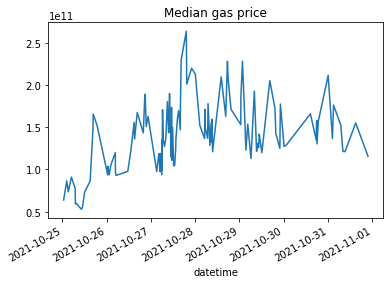

ETH reimbursements for the week (V1): 2.582503055007741


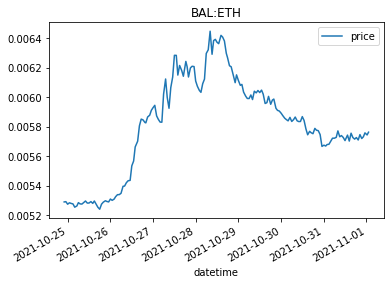

BAL reimbursements for the week (V1): 435.67059900485145
2021-11-01 17:18:29 - Querying Bigquery for eligible V2 swaps and reimbursement values ...
2021-11-01 17:18:44 - Done!


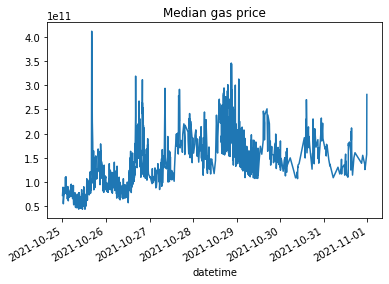

ETH reimbursements for the week (V2): 33.53046727741265


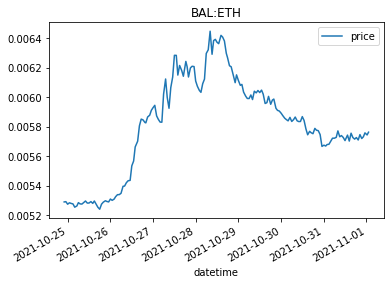

BAL reimbursements for the week (V2): 5635.848528166843

Reimbursements exceed budget (2041.9595617069572), capping...
Capped! 2039.9750265140308 BAL


In [14]:
from src.bal4gas_V1 import compute_bal_for_gas as compute_bal_for_gas_V1
from src.bal4gas_V2 import compute_bal_for_gas as compute_bal_for_gas_V2

if not REALTIME_ESTIMATOR:
    # get amount spent so far
    # 80k BAL were allocated to the program starting week 41
    BUDGET = 80000
    spent = 0
    for w in (range(41,WEEK)):
        week_spent = pd.read_json(
            f'reports/{w}/_gasReimbursement.json', 
            typ='series', 
            convert_dates=False).sum()
        spent += week_spent
    
    allowlist = pd.read_json(
        f'https://raw.githubusercontent.com/balancer-labs/assets/master/generated/bal-for-gas.json', 
        orient='index').loc['homestead'].values
    gas_allowlist = pd.Series(allowlist).str.lower().tolist()
    gas_allowlist.append('0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee')

    
    v1 = compute_bal_for_gas_V1(week_start_timestamp, week_end_timestamp, gas_allowlist, plot=True, verbose=True)

    gas_allowlist.remove('0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee')
    gas_allowlist.append('0x0000000000000000000000000000000000000000')
    v2 = compute_bal_for_gas_V2(week_start_timestamp, week_end_timestamp, gas_allowlist, plot=True, verbose=True)
    
    merge = v1.append(v2)
    # take budget into account
    budget_left = BUDGET-spent
    if (merge['bal_reimbursement'].sum() > budget_left):
        print(f'\nReimbursements exceed budget ({budget_left}), capping...')
        merge = merge.sort_values('datetime')
        in_budget = merge.cumsum()['bal_reimbursement'] <= budget_left
        merge = merge[in_budget]
        week_spend = merge['bal_reimbursement'].sum()
        print(f'Capped! {week_spend} BAL')

    totals_bal4gas = merge[['address','bal_reimbursement']].groupby('address').sum()['bal_reimbursement']
    totals_bal4gas[totals_bal4gas>=CLAIM_THRESHOLD].apply(\
       lambda x: format(x, f'.{CLAIM_PRECISION}f')).to_json(reports_dir+'/_gasReimbursement.json',
       indent=4)

    # combine BAL from liquidity mining and gas reimbursements
    totals = mainnet_BAL.add(totals_bal4gas, fill_value=0)
    totals[totals>=CLAIM_THRESHOLD].apply(\
       lambda x: format(x, f'.{CLAIM_PRECISION}f')).to_json(reports_dir+'/_totals.json',
       indent=4)

In [15]:
if not REALTIME_ESTIMATOR:
    print('Final Check Totals BAL')
    
    
    _ethereum = pd.read_json(
        get_export_filename(networks[1], BAL_addresses[1]), 
        typ='series', 
        convert_dates=False).sum()

    _polygon = pd.read_json(
        get_export_filename(networks[137], BAL_addresses[137]), 
        typ='series', 
        convert_dates=False).sum()
    
    _arbitrum = pd.read_json(
        get_export_filename(networks[42161], BAL_addresses[42161]), 
        typ='series', 
        convert_dates=False).sum()
    
    
    _lm_all_networks = pd.read_json(reports_dir+'/_totalsLiquidityMining.json', orient='index').sum().values[0]
    _claim = pd.read_json(reports_dir+'/_totals.json', orient='index').sum().values[0]
    print(f'Liquidity Mining Ethereum: {format(_ethereum, f".{CLAIM_PRECISION}f")}')
    print(f'Liquidity Mining Polygon: {format(_polygon, f".{CLAIM_PRECISION}f")}')
    print(f'Liquidity Mining Arbitrum: {format(_arbitrum, f".{CLAIM_PRECISION}f")}')
    print(f'Liquidity Mining All Networks: {format(_lm_all_networks, f".{CLAIM_PRECISION}f")}')
    print(f'Gas Reimbursement week {WEEK}: {format(_claim-_ethereum, f".{CLAIM_PRECISION}f")}')
    print(f'Claims: {format(_claim, f".{CLAIM_PRECISION}f")}')
    
    # apply threshold to BAL distributed on Polygon
    polygon = pd.read_json(
            get_export_filename(networks[137], BAL_addresses[137]), 
            typ='series', 
            convert_dates=False)
    threshold = 0.001
    filename = reports_dir+'/_polygon_BAL_with_threshold.json'
    polygon[polygon>threshold].to_json(filename, indent=4)
    polygon = pd.read_json(filename, typ='series', convert_dates=False).sum()
    
    # check all reports files
    print('\nReports totals:')
    checks = {}
    for f in os.listdir(reports_dir):
        _sum = pd.read_json(reports_dir+'/'+f, orient='index').sum().values[0]
        checks[f] = _sum
    display(pd.DataFrame.from_dict(checks, orient='index', columns=['total']).sort_index())

Final Check Totals BAL
Liquidity Mining Ethereum: 105799.999999999985
Liquidity Mining Polygon: 24999.999999999825
Liquidity Mining Arbitrum: 14200.000000000002
Liquidity Mining All Networks: 144999.999999999825
Gas Reimbursement week 74: 2039.975026514046
Claims: 107839.975026514032

Reports totals:


,total
__arbitrum_0x040d1edc9569d4bab2d15287dc5a4f10f56a56b8.json,1.420000e+04
__arbitrum_0x4e352cf164e64adcbad318c3a1e222e9eba4ce42.json,1.260000e+03
__arbitrum_0x965772e0e9c84b6f359c8597c891108dcf1c5b1a.json,1.023000e+03
__ethereum_0x226f7b842e0f0120b7e194d05432b3fd14773a9d.json,3.750000e+05
__ethereum_0x5a98fcbea516cf06857215779fd812ca3bef1b32.json,7.500000e+04
__ethereum_0x81f8f0bb1cb2a06649e51913a151f0e7ef6fa321.json,4.700000e+03
__ethereum_0xba100000625a3754423978a60c9317c58a424e3d.json,1.058000e+05
__polygon_0x580a84c73811e1839f75d86d75d88cca0c241ff4.json,3.000000e+04
__polygon_0x9a71012b13ca4d3d0cdc72a177df3ef03b0e76a3.json,2.500000e+04
__polygon_0xF501dd45a1198C2E1b5aEF5314A68B9006D842E0.json,1.500000e+04
